<a href="https://colab.research.google.com/github/Systeria-Inamayer/Keio_Quant_Macro_Assignment_2/blob/main/Quantmacro_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):
    # Function to implement Tauchen's method for discretizing a continuous state space
    # Inputs:
    # n: number of grid points
    # mu: mean of the AR(1) process
    # rho: AR(1) coefficient
    # sigma: standard deviation of the error term
    # Outputs:
    # transition_matrix: n x n transition matrix
    # state_space: n x 1 vector of state space points

    m = 1 / np.sqrt(1 - rho**2)

    # Compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # Compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n - 1)

    # Compute the transition probabilities
    transition_matrix = np.zeros((n, n))
    for i in range(n): # today state
        for j in range(n): # tomorrow state
            if j == 0: # prob going to the lower limit
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1: # prob going to the upper limit
                transition_matrix[i, j] = 1 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                z_low = (state_space[j] - rho*state_space[i] - d/2) / sigma # the lower bound
                z_high = (state_space[j] - rho*state_space[i] + d/2) / sigma # the higher bound
                transition_matrix[i, j] = norm.cdf(z_high) - norm.cdf(z_low)

    return transition_matrix, state_space

In [2]:
import numpy as np

# function to comile parameters into one thing "parameter"
def setPar(
    sigma = 1.50, # risk aversion
    beta = 0.98, # subjective discount factor
    delta = 0.03, # depreciation
    alpha = 0.25, # capital’s share of income
    rho = 0.6, # labor productivity persistence
    a_l = 0, # lower bound of asset grids
    a_u = 20, # upper bound of asset grids
    NH = 2, # number of grids of h
    NA = 401, # number of grids of a
    tax = 0.05 #tax rate of capital*interest
    ):

    # labor productivity variance.
    sigma_eps = np.sqrt(0.6*(1-rho**2))

    # making grids for ln h and solving for income transition probability using Tauchen's method.
    pi, h = tauchen(NH, -0.7, rho, sigma_eps)
    #pi is the probability of each income level in the next period based on current income level
    #h is the grid borders

    h = np.exp(h) # changing ln h grids to h grids

    # derive the stationary distribution from income transition process

    probst = np.ones((NH))/NH # setting the guess probability to a uniform distribution
    test = 10.0 # initialize the distance to a big number

    while test > 1e-8: # loop until convergence of the stationary distribution
        probst_new = np.zeros((NH)) # initialize new distribution
        for ih in range(NH): # today h
            for ihp in range(NH): # tomorrow h
                probst_new[ihp] += pi[ih, ihp]*probst[ih]

        test = np.max(np.abs(probst_new - probst)) # calculate the difference between the guess and the new distribution
        probst = probst_new # updating the guess

    HH = np.sum(h*probst) # aggregate effective labor

	  # create dictionary with parameters
    param = {}
    param['sigma'] = sigma; param['beta'] = beta; param['delta'] = delta;
    param['alpha'] = alpha; param['probst'] = probst;
    param['a_l'] = a_l; param['a_u'] = a_u; param['NH'] = NH; param['NA'] = NA;
    param['pi'] = pi; param['h'] = h; param['HH'] = HH; param['tax'] = tax;

    return param


In [3]:
def solve_household_gs(param, r, w, TT):
#労働所得税なら、ここにτが必要だよね。

    # opening the box of "param" to some parameters
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH']; tax = param['tax']

    # Create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize the utility function to a large negative number for zero or negative consumption
    util = np.full((NA, NA, NH), -10000.0)

    # Calculate utility if the agent chooses asset a[iap] for each asset combination a[ia] and income shock h[ih]
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):

                cons = w*h[ih] + a[ia] + (1 - tax) * r * a[ia] + TT[ih] - a[iap]  #added tax to a[ia], added dividend
                #is TT[ih] correct?

                #cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]  #a[iap]はaの中に入っている貯金の選択肢の内iap番目を選んだから、具体的な数値はa[iap]になる
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)


    # Initialize some variables
    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    # Iterate on Bellman's equation and get the decision rules and the value function at the optimum
    test = 10
    while test != 0: # loop until policy function converges　答えが整数だから、収束するまで回せる
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih] #今期のutility
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp] #次以降の期のutilityをforで全部追加する

        # Finding max of reward
        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih]) # finding the maximal value
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih]) # finding the index of the maximizer

        test = np.max(iaplus_new - iaplus) # stop if iaplus converges
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus] #aは数値自体 iaはその数値のindex

    # optimal consumption
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + a[ia] + (1 - tax) * r * a[ia] + TT[ih] - aplus[ia, ih]

    return aplus, iaplus, c

In [4]:
def get_distribution(param, decisions):

    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi'];
    NA = param['NA']; NH = param['NH'];
    iaplus = decisions[1]

    # Generate a linearly spaced vector of NA values between a_l and a_u
    a = np.linspace(a_l, a_u, NA)

    test = 10 # Initialize a test value to be greater than 10^-8
    phi = np.ones((NA, NH)) / NA / NH # Initialize the distribution phi to be uniform
                                      #　全部１にしたけど、NAとNHで割ることによって合計が１になるようにしている

    # Loop until the test value is less than 10^-8
    while test > 1e-8:
        phi_new = np.zeros((NA, NH)) # Initialize a new distribution phi_new to be all zeros
        # Loop over all values of a, h, and h'
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    # Update phi_new using the interpolation indices, blending coefficients, and probabilities
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]
        test = np.max(np.abs(phi_new - phi)) # Calculate the maximum difference between phi_new and phi
        phi = phi_new # Update phi to be phi_new

    return phi

In [10]:
def model_solution(param):

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']
    probst = param['probst']
    tax = param['tax']

    phi = 0.2 # updating share
    toler = 1e-3 # warning: this doens't converge if tolerance is too small
    test = 10 # initial difference
    KK = 10.0 # initial capital

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')
#ちゃんとtestがtolerより初期の状態で大きいことを確認
    while test > toler:
        #step 1
        # calculate rental rate of capital and w from firm FOC

        w = (1-alpha) * KK**(alpha) * HH**(-alpha)
        r = (alpha) * KK**(alpha-1) * HH**(1-alpha) - delta

        ### Government budget
        TT = (tax * r * KK) * probst
        print(TT)

        #probst is the distribution of households? in each income bracket???
        #so this is the distribution of TT to each household bracket?
        #probst is [○○ , ○○] so 2 brackets

        #divide by the amount of people in each bracket? no

        ####################################################
        # Solving for households optimization (policy function of assets)
        #step 2
        ####################################################

        decisions = solve_household_gs(param, r, w, TT)

        aplus = decisions[0] # note that the first component (index 0) of decisions is defines as aplus

        ####################################################
        # Loop for finding eq distribution and capital
        #step 3
        ####################################################

        # eq distribution

        mu = get_distribution(param, decisions)

        # new aggregate capital
        # is this the capital? or is KK capital?
        KK_new = np.sum(mu*aplus)

        ####################################################
        # Loop for finding eq capital
        ####################################################

        # form metric and update KK

        test = abs((KK_new - KK)/KK) # loop until K converges
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # update K

    return decisions, r, w, KK, HH, mu, TT

In [11]:
import matplotlib.pyplot as plt

param = setPar()
#print(param['probst'])
(decisions, r, w, KK, HH, mu, TT) = model_solution(param)



ITERATING ON KK

  metric    Kold      Knew
[0.00120523 0.00402188]
['0.5632', '10.0000', '4.3675']
[0.00145755 0.00486388]
['0.4032', '8.8735', '5.2957']
[0.00161088 0.00537555]
['0.1804', '8.1580', '6.6859']
[0.00167217 0.00558005]
['0.0070', '7.8635', '7.9183']
[0.0016699  0.00557251]
['0.0031', '7.8745', '7.8497']
[0.00167093 0.00557592]
['0.0056', '7.8695', '7.8251']
[0.00167276 0.00558203]
['0.0011', '7.8607', '7.8690']
[0.00167242 0.00558088]
['0.0037', '7.8623', '7.8912']
[0.00167122 0.00557691]
['0.0004', '7.8681', '7.8646']


(0.2983443573391545, 0.2992195020722115, 0.30009464680526843, 0.3009697915383254, 0.3018449362713824, 0.30272008100443937, 0.30359522573749637, 0.3044703704705533, 0.3053455152036103, 0.3062206599366673, 0.30709580466972425, 0.30797094940278125, 0.30884609413583824, 0.3097212388688952, 0.3105963836019522, 0.31147152833500913, 0.3123466730680661, 0.3132218178011231, 0.31409696253418007, 0.31497210726723707, 0.31584725200029407, 0.316722396733351, 0.317597541466408, 0.318472686199465, 0.31934783093252195, 0.32022297566557895, 0.3210981203986359, 0.3219732651316929, 0.3228484098647499, 0.32372355459780683, 0.3245986993308638, 0.3254738440639208, 0.32634898879697777, 0.32722413353003477, 0.3280992782630917, 0.3289744229961487, 0.3298495677292057, 0.33072471246226265, 0.33159985719531965, 0.33247500192837665, 0.3333501466614336, 0.3342252913944906, 0.3351004361275476, 0.33597558086060453, 0.3368507255936615, 0.33772587032671847, 0.33860101505977547, 0.33947615979283247, 0.3403513045258894, 

Text(0, 0.5, '% OF AGENTS')

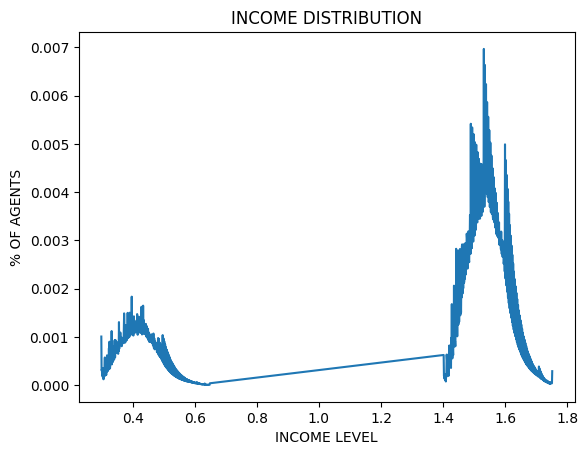

In [53]:
h = param['h']
a_l = param['a_l']; a_u = param['a_u']; NA = param['NA'];
tax = param['tax']; NH = param['NH']
a = np.linspace(a_l, a_u, NA)

#print(h)
# calculate income distribution for each grid
#

# need to add TT to this but how? is this right? I have no idea
income = np.array([((1 - tax) * r*a + w*h[0] + TT[0]), ((1 - tax) * r*a + w*h[1] + TT[1])])
#print(income)
# # transpose income　行列を縦横ひっくり返すため。income順にソートしたいから
income = income.T
# # sorting the income after flattening "income"
# pinc, index = np.sort(income.flatten('F')), np.argsort(income.flatten('F'))
# plambda = mu.flatten('F')
# #

# sort with regard to the 1st argument of zip
zip_lists = zip(income.flatten('F'), mu.flatten('F'))
# sort upwards
zip_sort = sorted(zip_lists)
# unzip
pinc, plambda = zip(*zip_sort)
#これはincomeとμを大きさ順に並び替えたやつ
print(pinc)
#GINI coefficient for income
#how do i calculate gini using the numbers here?
#total = 0
#for ih in range(NH):
#    total = total * 2
#    total += zip_sort[ih]
print(sum(pinc))
print(sum(plambda))

#plambda is the percentages
#pinc is the income
#finding the smallest width of the columns to calculate gini coefficient with   not anymore
#width = min(plambda)
#print(width)

#lorenze curve
#e1 = sum(pinc)
#pinc2 = pinc / e1
#total = 0
#straddle = 0
#for ih in range(NH):
#    leftover = plambda[ih]
#    while width <= leftover:
#        if straddle > 0:
#            total = total * 2
 #           total += straddle * pinc2[ih - 1] + (width - straddle) * pinc2[ih]
#            leftover = plambda[ih] - (width - straddle)
#            straddle = 0
#
#        else:
#            total = total * 2
#            total += width * pinc2[ih]
#            leftover = leftover - width
#
#    straddle = width - leftover

total = 0
totalinc = 0
iterate = len(pinc)
print(iterate)
count = 1
while count <= iterate:
    total += (plambda[ih] * totalinc) + (plambda[ih] * pinc[ih]) / 2
    totalinc += pinc[ih]
    count += 1

lorenze = total
#print(lorenze)

equal = (sum(pinc) * sum(plambda)) / 2
gini = lorenze / equal
print(gini)

#total = 0
#for ih in range(NH):
#    total = total * 2
#    total += pinc[ih] * plambda[ih]



plt.plot(pinc, plambda)
plt.title('INCOME DISTRIBUTION')
plt.xlabel('INCOME LEVEL')
plt.ylabel('% OF AGENTS')

[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15
  1.2   1.25  1.3   1.35  1.4   1.45  1.5   1.55  1.6   1.65  1.7   1.75
  1.8   1.85  1.9   1.95  2.    2.05  2.1   2.15  2.2   2.25  2.3   2.35
  2.4   2.45  2.5   2.55  2.6   2.65  2.7   2.75  2.8   2.85  2.9   2.95
  3.    3.05  3.1   3.15  3.2   3.25  3.3   3.35  3.4   3.45  3.5   3.55
  3.6   3.65  3.7   3.75  3.8   3.85  3.9   3.95  4.    4.05  4.1   4.15
  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55  4.6   4.65  4.7   4.75
  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15  5.2   5.25  5.3   5.35
  5.4   5.45  5.5   5.55  5.6   5.65  5.7   5.75  5.8   5.85  5.9   5.95
  6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35  6.4   6.45  6.5   6.55
  6.6   6.65  6.7   6.75  6.8   6.85  6.9   6.95  7.    7.05  7.1   7.15
  7.2   7.25  7.3   7.35  7.4   7.45  7.5   7.55  7.6   7.65  7.7   7.75
  7.8   7.85  7.9   7.95  8.    8.05  8.1   8.15  8

Text(0, 0.5, '% OF AGENTS')

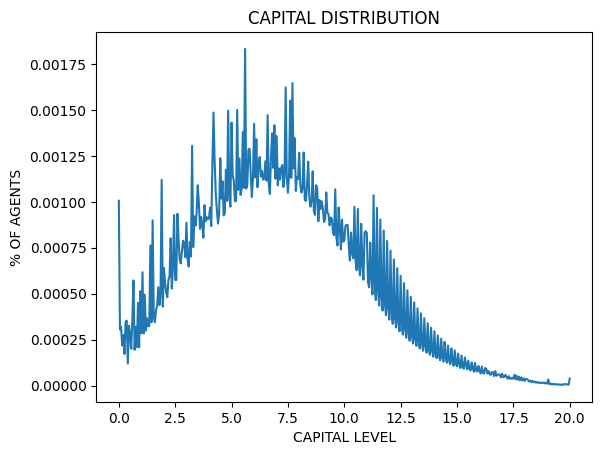

In [15]:
#for capital graph

h = param['h']
a_l = param['a_l']; a_u = param['a_u']; NA = param['NA'];
a = np.linspace(a_l, a_u, NA)

# calculate capital distribution for each grid
#no idea if this is right. ???
capital = np.array([a])
print(capital)
#capital = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
# # transpose capital　行列を縦横ひっくり返すため。income順にソートしたいから
capital = capital.T
# # sorting the income after flattening "income"
# pinc, index = np.sort(income.flatten('F')), np.argsort(income.flatten('F'))
# plambda = mu.flatten('F')
#

# sort with regard to the 1st argument of zip
zip_lists = zip(capital.flatten('F'), mu.flatten('F')) #mu?
# sort upwards
zip_sort = sorted(zip_lists)
# unzip
pinc, plambda = zip(*zip_sort)
#これはincomeとμを大きさ順に並び替えたやつ

plt.plot(pinc, plambda)
plt.title('CAPITAL DISTRIBUTION')
plt.xlabel('CAPITAL LEVEL')
plt.ylabel('% OF AGENTS')

In [33]:
alpha = param['alpha']

#
#Calculating GDP using production function Y = F(K,L)
GDP = KK ** alpha * HH ** (1 - alpha)

#        w = (1-alpha) * KK**(alpha) * HH**(-alpha)
#        r = (alpha) * KK**(alpha-1) * HH**(1-alpha) - delta

print(GDP)


change = ((GDP / 1.5323661750492144) - 1) * 100
print(((GDP - 1.5323661750492144)/1.5323661750492144)*100)
print(change)

1.5239883761808775
-0.5467230355739109
-0.546723035573915


In [36]:
mu

array([[1.00604921e-03, 6.23955291e-04],
       [3.04229404e-04, 1.88684155e-04],
       [3.19729793e-04, 1.98297552e-04],
       [2.17976862e-04, 1.35190023e-04],
       [2.74937825e-04, 1.70517414e-04],
       [1.71533751e-04, 1.06385841e-04],
       [3.46494785e-04, 2.14897295e-04],
       [3.53167696e-04, 2.19035858e-04],
       [1.19978463e-04, 7.44110687e-05],
       [3.25477761e-04, 2.01862462e-04],
       [2.77920217e-04, 1.72367105e-04],
       [1.99958426e-04, 6.32003459e-04],
       [3.61434927e-04, 5.39221520e-04],
       [5.72204846e-04, 4.64947433e-04],
       [1.94389968e-04, 2.59386851e-04],
       [3.17879178e-04, 2.83763043e-04],
       [2.09462181e-04, 3.04866237e-04],
       [4.50288320e-04, 4.57596844e-04],
       [2.08008589e-04, 1.89588889e-04],
       [5.13676742e-04, 6.23260407e-04],
       [2.85068260e-04, 6.91341225e-04],
       [6.16896313e-04, 8.21604509e-04],
       [2.83260413e-04, 5.54212645e-04],
       [4.95257668e-04, 5.18338464e-04],
       [2.994322